In [1]:
!pip install kaggle

In [2]:
# configure the path of kaggle.jason file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# API to fetch the dataset from kaggle
import kagglehub

!kaggle datasets download -d "feyzazkefe/trashnet"

Dataset URL: https://www.kaggle.com/datasets/feyzazkefe/trashnet
License(s): unknown
 98% 40.0M/40.8M [00:01<00:00, 29.6MB/s]
100% 40.8M/40.8M [00:01<00:00, 26.4MB/s]


In [4]:
# extract zip file
from zipfile import ZipFile
file_name = "/content/trashnet.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')

finish


In [5]:
# import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
base_dir = '/content/dataset-resized'

# Data Augmentation and Rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # use 20% of data for validation
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


In [7]:
train_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # using 224x224 for transfer learning compatibility
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [8]:
# Number of classes
num_classes = len(train_data.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [9]:
# Load the MobileNetV2 base model (pretrained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pretrained weights
base_model.trainable = False

# Add custom layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # Batch normalization layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Regularization
    Dense(num_classes, activation='softmax')  # Output layer
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,428,358 (9.26 MB)

 Trainable params: 167,558 (654.52 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [11]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [12]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,  # Adjust epochs as needed
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 758ms/step - accuracy: 0.4737 - loss: 1.6951 - val_accuracy: 0.6620 - val_loss: 0.8568 - learning_rate: 0.0010
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step - accuracy: 0.6945 - loss: 0.8999 - val_accuracy: 0.6779 - val_loss: 0.8097 - learning_rate: 0.0010
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 501ms/step - accuracy: 0.7253 - loss: 0.8044 - val_accuracy: 0.7296 - val_loss: 0.7268 - learning_rate: 0.0010
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 532ms/step - accuracy: 0.7659 - loss: 0.6903 - val_accuracy: 0.7396 - val_loss: 0.7496 - learning_rate: 0.0010
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - accuracy: 0.7819 - loss: 0.6258 - val_accuracy: 0.7058 - val_loss: 0.7915 - learning_rate: 0.0010
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.7902 - loss: 0.5843 - val_accuracy: 0.7535 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 461ms/step - accuracy: 0.8108 - loss: 0.5183 - val_

In [13]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.7469 - loss: 0.7151
Validation Accuracy: 76.94%


In [14]:
# Classification Report and Confusion Matrix
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(val_data.classes, y_pred, target_names=val_data.class_indices.keys()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 497ms/step
              precision    recall  f1-score   support

   cardboard       0.15      0.12      0.14        80
       glass       0.20      0.23      0.21       100
       metal       0.15      0.16      0.15        82
       paper       0.21      0.23      0.22       118
     plastic       0.23      0.20      0.21        96
       trash       0.09      0.07      0.08        27

    accuracy                           0.19       503
   macro avg       0.17      0.17      0.17       503
weighted avg       0.19      0.19      0.19       503



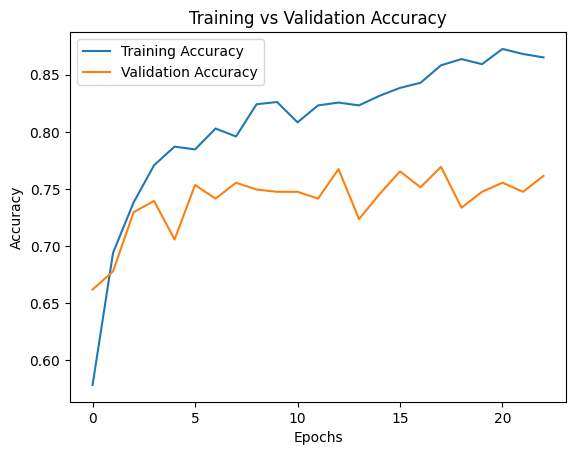

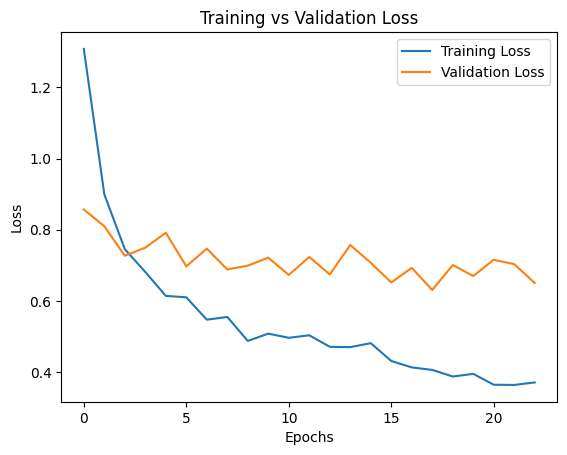

In [15]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()


In [16]:
# Save Model
model.save('trashnet_model.h5')